# Python version - Supermodel 

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [2]:
def dNdt(H, P, PH, N, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    m_H = parameters_dict['m_H'] # Herbivore mortality 
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    m_P = parameters_dict['m_P'] # Predator mortality
    #Unpacking phytoplankton and nutrients parameters: 
    v_m = parameters_dict['v_m'] # max growth rate of phytoplankton
    k_s = parameters_dict['k_s'] # half saturation constant
    m_ph = parameters_dict['m_ph'] # phytoplankton mortality 
    y = parameters_dict['y'] # unassimilated phytoplankton 
    #Unpacking grazing parameters: 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    #more timesteps
    #dt = parameters_dict['dt']
    
    #Calculate the derivative 
    #grazing_t1 = r_m * (kg**-1 * PH * (1 - math.exp(-kg**-1 * PH))) * H
    
    #dH = ((1-y) * r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H)*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H - m_H*H
    dH = r_H*H*(1-H/K_H) + ((1-y) * r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H)*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H - m_H*H
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P - m_P * P 
    dPH = ((v_m * N * PH)/(k_s + N)) - (m_ph * PH) - ((r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH)))) * H)
    dN = -((v_m * N * PH)/(k_s + N)) + (m_ph * PH) + (m_H * H) + (y * (r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH)))) * H) + (m_P * P)
    
    return dH, dP, dPH, dN

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0 
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [4]:
# Function to run the model 

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

# Test

In [5]:
numyears = 36500 # number of years to run simulation 

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.2/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = 0.0 # Effort for herbivore harvest
m_H = (0.01/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.2/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.1/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = 0.0 # Effort for predator harvest
m_P = (0.01/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }


In [6]:
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

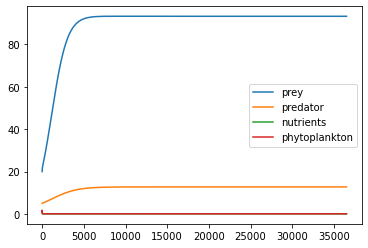

In [7]:
annual_time = (numyears)/365

plt.plot(H_array, label="prey")
plt.plot(P_array, label="predator")
plt.plot(N_array, label="nutrients")
plt.plot(PH_array, label="phytoplankton")
#plt.xticks(range(0, int(annual_time)+1, 10))
plt.legend()

### from days to years

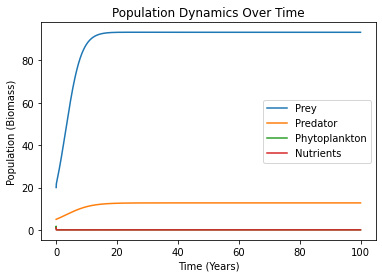

In [8]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label="Predator")
plt.plot(time_years, PH_array, label="Phytoplankton")
plt.plot(time_years, N_array, label="Nutrients")

plt.xlabel("Time (Years)")
plt.ylabel("Population (Biomass)")
plt.title("Population Dynamics Over Time")
plt.legend()

plt.savefig("figs/time_series_abundance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

In [9]:
print(N_array[-1])
print(PH_array[-1])
print(H_array[-1])
print(P_array[-1])

0.029798187530967853
0.06740120833608981
93.23991315028523
12.754676405983927


## Nutrient Scenarios

In [74]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']

    # Check if it's time to add a pulse of nutrients
    #if numyears % 30 == 0:
        #N_pulse = 10000  # Define the magnitude of the nutrient pulse
        #N += N_pulse  # Add the nutrient pulse

    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - q_H * E_H * H - m_H * H
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -((v_m * N * PH) / (k_s + N)) + (m_ph * PH) + (m_H * H) + (y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                m_P * P)

    return dH, dP, dPH, dN

In [75]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0
        
      # Check if it's time to add a pulse of nutrients
    #if numyears % 30 == 0:
        #N_pulse = 100  # Define the magnitude of the nutrient pulse
        #N += N_pulse  # Add the nutrient pulse
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [76]:
# Function to run the model 

## works for nutrients but nothing else 

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
  
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        
        #for i in range(numyears):
        # Check if it's time to add a pulse of nutrients
        if (i + 1) % 30 == 0:
            N_pulse = 1  # Define the magnitude of the nutrient pulse
            N_array[i + 1] += N_pulse  # Add the nutrient pulse
        
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

In [77]:
#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }

In [78]:
numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

Text(0, 0.5, 'Nutrients Biomass')

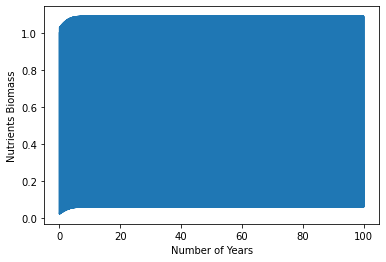

In [79]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, N_array)
plt.xlabel('Number of Years')
plt.ylabel('Nutrients Biomass')

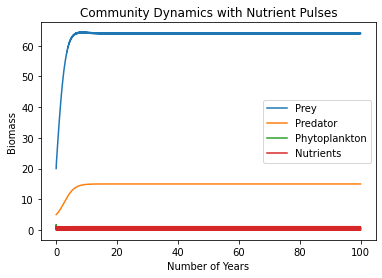

In [80]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Community Dynamics with Nutrient Pulses')

plt.show()

### Include N_pulse as a param

In [81]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']
    N_pulse = parameters_dict['N_pulse']

    # Check if it's time to add a pulse of nutrients
    #if numyears % 30 == 0:
        #N_pulse = 10000  # Define the magnitude of the nutrient pulse
        #N += N_pulse  # Add the nutrient pulse

    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - q_H * E_H * H - m_H * H
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -((v_m * N * PH) / (k_s + N)) + (m_ph * PH) + (m_H * H) + (y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                m_P * P)

    return dH, dP, dPH, dN

In [82]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0
        
      # Check if it's time to add a pulse of nutrients
    #if numyears % 30 == 0:
        #N_pulse = 100  # Define the magnitude of the nutrient pulse
        #N += N_pulse  # Add the nutrient pulse
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [83]:
## works for nutrients but nothing else 

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
  
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        
        #for i in range(numyears):
        # Check if it's time to add a pulse of nutrients
        if (i + 1) % 30 == 0:
            N_pulse = parameters_dict['N_pulse']  # Define the magnitude of the nutrient pulse
            N_array[i + 1] += N_pulse  # Add the nutrient pulse
        
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

In [84]:
#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 1
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

In [85]:
numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

Text(0, 0.5, 'Nutrients Biomass')

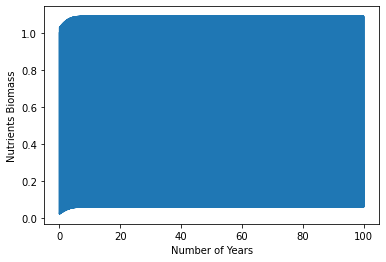

In [86]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, N_array)
plt.xlabel('Number of Years')
plt.ylabel('Nutrients Biomass')

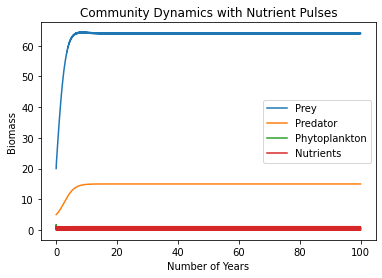

In [87]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Community Dynamics with Nutrient Pulses')

plt.show()

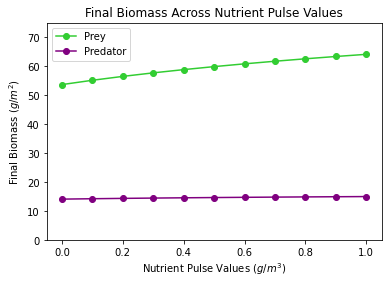

In [88]:
# Define the range of N_pulse_array values to plot
size = 11
N_pulse_array = np.linspace(0.0, 1.0, size)
N_final_array = np.zeros(size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, N_pulse in enumerate(N_pulse_array):
    parameters_dict['N_pulse'] = N_pulse
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    N_final_array[i] = np.mean(N_array[-3650:-1])
    H_final_array[i] = np.mean(H_array[-3650:-1])
    P_final_array[i] = np.mean(P_array[-3650:-1])

# Plot the final abundances
#plt.plot(N_pulse_array, N_final_array, label='Nutrients', color="red", marker="o")
plt.plot(N_pulse_array, H_final_array, label='Prey', color="limegreen", marker="o")
plt.plot(N_pulse_array, P_final_array, label='Predator', color="purple", marker="o")
#plt.plot(E_P_array, P_final_array, label='Predator', color="purple", marker="o")
plt.title('Final Biomass Across Nutrient Pulse Values')
plt.xlabel('Nutrient Pulse Values $(g/m^3)$')
plt.ylabel('Final Biomass $(g/m^2)$')
plt.ylim(0,75)
plt.legend()

plt.savefig("figs/N_pulse_biomasses.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

# Show the plot
plt.show()

In [67]:
print(P_final_array)

[14.09816629 14.23472333 14.35439885 14.46072631 14.55622726 14.64276764
 14.72176874 14.79433913 14.86136067 14.92354667 14.98148249]


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

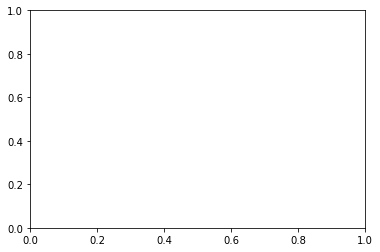

In [48]:
numyears = 36500 # number of years to run simulation 
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

# Define the range of N_pulse values
N_pulse_values = np.linspace(0, 1, 10)  # 101 values from 0 to 1

final_N_array_values = []

for N_pulse in N_pulse_values:
    parameters_dict['N_pulse'] = N_pulse
    
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    
    final_N_array_values = np.mean(N_array[-3650:-1])

# Plot the final N_array values against N_pulse values
plt.plot(N_pulse_values, final_N_array_values)
plt.xlabel('N_pulse')
plt.ylabel('Final N_array')
plt.title('Effect of N_pulse on Final N_array')
plt.grid(True)
plt.show()

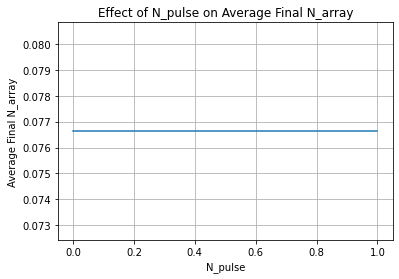

In [49]:
numyears = 36500 # number of years to run simulation 
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

# Define the range of N_pulse values
N_pulse_values = np.linspace(0, 1, 10)  # 10 values from 0 to 1

final_N_array_values = []

for N_pulse in N_pulse_values:
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    
    final_N_array_values.append(np.mean(N_array[-3650:-1]))  # Taking the mean of the last 10 years

# Plot the final N_array values against N_pulse values
plt.plot(N_pulse_values, final_N_array_values)
plt.xlabel('N_pulse')
plt.ylabel('Average Final N_array')
plt.title('Effect of N_pulse on Average Final N_array')
plt.grid(True)
plt.show()

### Fishing - Timeseries

In [9]:
numyears = 36500 # number of years to run simulation 

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.2/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.2/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }


In [10]:
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

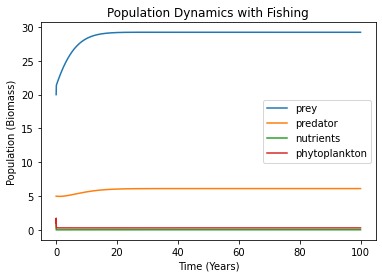

In [11]:
plt.plot(time_years, H_array, label="prey")
plt.plot(time_years, P_array, label="predator")
plt.plot(time_years, N_array, label="nutrients")
plt.plot(time_years, PH_array, label="phytoplankton")
plt.xlabel("Time (Years)")
plt.ylabel("Population (Biomass)")
plt.title("Population Dynamics with Fishing")
plt.legend()

## Prey abundances, prey fishing effort

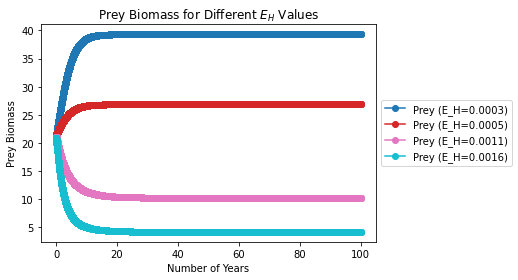

In [13]:
numyears = 36500 # number of years to run simulation 

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }

# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))


# Initialize lists to store predator and prey abundances for each E_H value
predator_abundances = []
prey_abundances = []

E_H_values = [0.1/365, 0.2/365, 0.4/365, 0.6/365]

# Define a color map
colors = plt.cm.tab10(np.linspace(0, 1, len(E_H_values)))

# Run the model for each E_H value
for E_H_value in E_H_values:
    parameters_dict['E_H'] = E_H_value # Update the E_H parameter in the parameters dictionary
    H_array, P_array, _, _, _, _, _ = run_model(H0, P0, PH0, N0, parameters_dict) # Run the model
    predator_abundances.append(P_array)# Append the final abundances of predator and prey to the respective lists
    prey_abundances.append(H_array)

# Plot the prey abundances against the number of years
for i, E_H_value in enumerate(E_H_values):
    rounded_E_H_value = round(E_H_value, 4)
    plt.plot(time_years, prey_abundances[i], label=f'Prey (E_H={rounded_E_H_value})', marker='o', color=colors[i])

    
# Add labels and legend
plt.xlabel('Number of Years')
plt.ylabel('Prey Biomass')
plt.title('Prey Biomass for Different $E_H$ Values')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figs/EH_prey_abundance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')
plt.show()

## Predator abundances, prey fishing effort

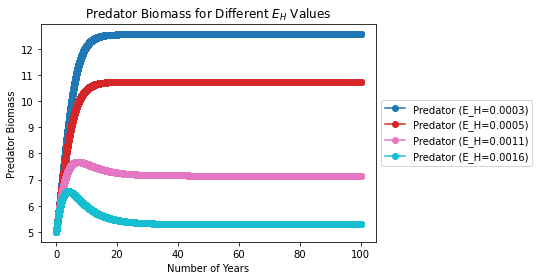

In [14]:
# Run the model for each E_H value
for E_H_value in E_H_values:
    # Update the E_H parameter in the parameters dictionary
    parameters_dict['E_H'] = E_H_value
    
    # Run the model with updated parameters
    H_array, P_array, _, _, _, _, _ = run_model(H0, P0, PH0, N0, parameters_dict)
    
    # Append the final abundances of predator and prey to the respective lists
    predator_abundances.append(P_array)
    prey_abundances.append(H_array)

# Plot the predator and prey abundances against the number of years
for i, E_H_value in enumerate(E_H_values):
    rounded_E_H_value = round(E_H_value, 4)
    plt.plot(time_years, predator_abundances[i], label=f'Predator (E_H={rounded_E_H_value})', marker='o', color=colors[i])

# Add labels and legend
plt.xlabel('Number of Years')
plt.ylabel('Predator Biomass')
plt.title('Predator Biomass for Different $E_H$ Values')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figs/EH_predator_abundance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')
plt.show()

## Predator abundances, predator fishing effort

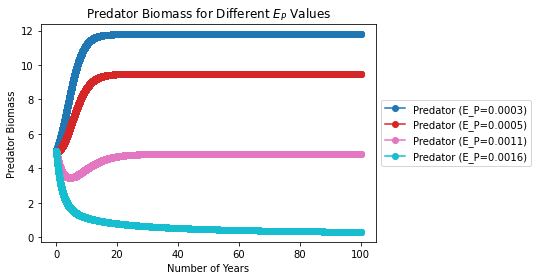

In [15]:
numyears = 36500 # number of years to run simulation 

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }

# Initialize lists to store predator and prey abundances for each E_H value
predator_abundances = []
prey_abundances = []

E_P_values = [0.1/365, 0.2/365, 0.4/365, 0.6/365]

# Run the model for each E_H value
for E_P_value in E_P_values:
    # Update the E_H parameter in the parameters dictionary
    parameters_dict['E_P'] = E_P_value
    
    # Run the model with updated parameters
    H_array, P_array, _, _, _, _, _ = run_model(H0, P0, PH0, N0, parameters_dict)
    
    # Append the final abundances of predator and prey to the respective lists
    predator_abundances.append(P_array)
    prey_abundances.append(H_array)

# Plot the predator and prey abundances against the number of years
for i, E_P_value in enumerate(E_P_values):
    rounded_E_P_value = round(E_P_value, 4)
    plt.plot(time_years, predator_abundances[i], label=f'Predator (E_P={rounded_E_P_value})', marker='o', color=colors[i])

# Add labels and legend
plt.xlabel('Number of Years')
plt.ylabel('Predator Biomass')
plt.title('Predator Biomass for Different $E_P$ Values')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figs/EP_predator_abundance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')
plt.show()

## Prey abundances, predator fishing effort

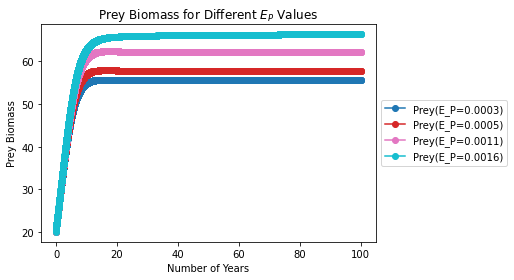

In [16]:
# Initialize lists to store predator and prey abundances for each E_H value
predator_abundances = []
prey_abundances = []

E_P_values = [0.1/365, 0.2/365, 0.4/365, 0.6/365]

# Run the model for each E_H value
for E_P_value in E_P_values:
    # Update the E_H parameter in the parameters dictionary
    parameters_dict['E_P'] = E_P_value
    
    # Run the model with updated parameters
    H_array, P_array, _, _, _, _, _ = run_model(H0, P0, PH0, N0, parameters_dict)
    
    # Append the final abundances of predator and prey to the respective lists
    predator_abundances.append(P_array)
    prey_abundances.append(H_array)

# Plot the predator and prey abundances against the number of years
for i, E_P_value in enumerate(E_P_values):
    rounded_E_P_value = round(E_P_value, 4)
    plt.plot(time_years, prey_abundances[i], label=f'Prey(E_P={rounded_E_P_value})', marker='o', color=colors[i])

# Add labels and legend
plt.xlabel('Number of Years')
plt.ylabel('Prey Biomass')
plt.title('Prey Biomass for Different $E_P$ Values')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figs/EP_prey_abundance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')
plt.show()

## Nutrients, phytoplankton - prey fishing

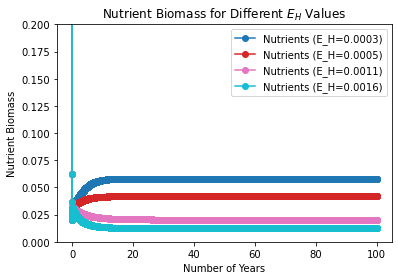

In [17]:
numyears = 36500 # number of years to run simulation 

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }


# Initialize lists to store predator and prey abundances for each E_H value
predator_abundances = []
prey_abundances = []
nutrient_abundances = []
phytoplankton_abundances = []

E_H_values = [0.1/365, 0.2/365, 0.4/365, 0.6/365]

# Run the model for each E_H value
for E_H_value in E_H_values:
    # Update the E_H parameter in the parameters dictionary
    parameters_dict['E_H'] = E_H_value
    
    # Run the model with updated parameters
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    
    # Append the final abundances of predator and prey to the respective lists
    predator_abundances.append(P_array)
    prey_abundances.append(H_array)
    nutrient_abundances.append(N_array)
    phytoplankton_abundances.append(PH_array)

# Plot the predator and prey abundances against the number of years
for i, E_H_value in enumerate(E_H_values):
    rounded_E_H_value = round(E_H_value, 4)
    plt.plot(time_years, nutrient_abundances[i], label=f'Nutrients (E_H={rounded_E_H_value})', marker='o', color=colors[i])
    
    

# Add labels and legend
plt.xlabel('Number of Years')
plt.ylabel('Nutrient Biomass')
plt.title('Nutrient Biomass for Different $E_H$ Values')
plt.legend()
plt.ylim(0,0.2)


plt.show()

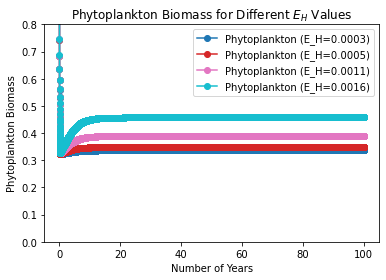

In [18]:
# Initialize lists to store predator and prey abundances for each E_H value
predator_abundances = []
prey_abundances = []
nutrient_abundances = []
phytoplankton_abundances = []

E_H_values = [0.1/365, 0.2/365, 0.4/365, 0.6/365]

# Run the model for each E_H value
for E_H_value in E_H_values:
    # Update the E_H parameter in the parameters dictionary
    parameters_dict['E_H'] = E_H_value
    
    # Run the model with updated parameters
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    
    # Append the final abundances of predator and prey to the respective lists
    predator_abundances.append(P_array)
    prey_abundances.append(H_array)
    nutrient_abundances.append(N_array)
    phytoplankton_abundances.append(PH_array)

# Plot the predator and prey abundances against the number of years
for i, E_H_value in enumerate(E_H_values):
    rounded_E_H_value = round(E_H_value, 4)
    plt.plot(time_years, phytoplankton_abundances[i], label=f'Phytoplankton (E_H={rounded_E_H_value})', marker='o', color=colors[i])
    

# Add labels and legend
plt.xlabel('Number of Years')
plt.ylabel('Phytoplankton Biomass')
plt.title('Phytoplankton Biomass for Different $E_H$ Values')
plt.legend()
plt.ylim(0,0.8)

plt.show()

## Combine Panels into subplot

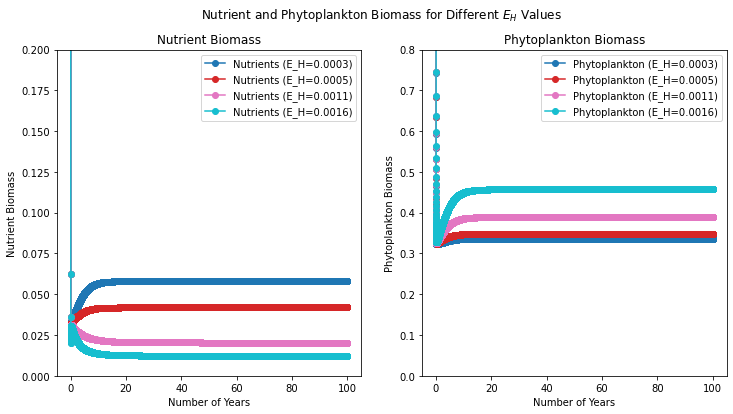

In [19]:
# Initialize lists to store predator and prey abundances for each E_H value
predator_abundances = []
prey_abundances = []
nutrient_abundances = []
phytoplankton_abundances = []

E_H_values = [0.1/365, 0.2/365, 0.4/365, 0.6/365]

# Run the model for each E_H value
for E_H_value in E_H_values:
    # Update the E_H parameter in the parameters dictionary
    parameters_dict['E_H'] = E_H_value
    
    # Run the model with updated parameters
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    
    # Append the final abundances of predator and prey to the respective lists
    predator_abundances.append(P_array)
    prey_abundances.append(H_array)
    nutrient_abundances.append(N_array)
    phytoplankton_abundances.append(PH_array)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot nutrient abundances
for i, E_H_value in enumerate(E_H_values):
    rounded_E_H_value = round(E_H_value, 4)
    ax1.plot(time_years, nutrient_abundances[i], label=f'Nutrients (E_H={rounded_E_H_value})', marker='o', color=colors[i])

ax1.set_xlabel('Number of Years')
ax1.set_ylabel('Nutrient Biomass')
ax1.set_title('Nutrient Biomass')
ax1.legend()
ax1.set_ylim(0, 0.2)

# Plot phytoplankton abundances
for i, E_H_value in enumerate(E_H_values):
    rounded_E_H_value = round(E_H_value, 4)
    ax2.plot(time_years, phytoplankton_abundances[i], label=f'Phytoplankton (E_H={rounded_E_H_value})', marker='o', color=colors[i])

ax2.set_xlabel('Number of Years')
ax2.set_ylabel('Phytoplankton Biomass')
ax2.set_title('Phytoplankton Biomass')
ax2.legend()
ax2.set_ylim(0, 0.8)

# Add a title to the entire figure
plt.suptitle('Nutrient and Phytoplankton Biomass for Different $E_H$ Values')
#plt.tight_layout()

plt.savefig("figs/EH_N_PH_abundance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')


plt.show()

## Nutrients and Phytoplankton, Predator Fishing

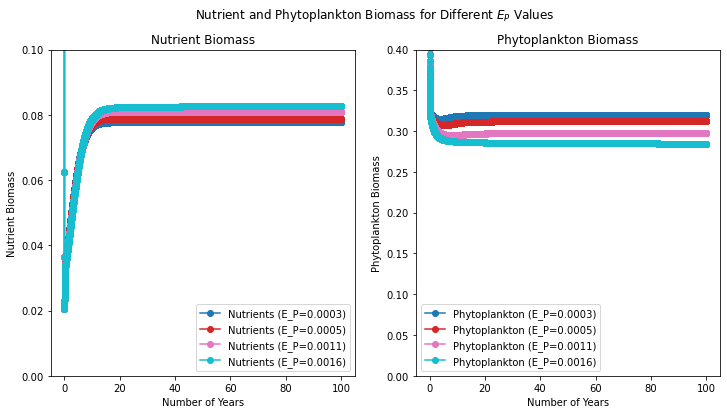

In [20]:
numyears = 36500 # number of years to run simulation 

#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }

# Initialize lists to store predator and prey abundances for each E_H value
predator_abundances = []
prey_abundances = []
nutrient_abundances = []
phytoplankton_abundances = []

E_P_values = [0.1/365, 0.2/365, 0.4/365, 0.6/365]

# Run the model for each E_P value
for E_P_value in E_P_values:
    # Update the E_H parameter in the parameters dictionary
    parameters_dict['E_P'] = E_P_value
    
    # Run the model with updated parameters
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    
    # Append the final abundances of predator and prey to the respective lists
    predator_abundances.append(P_array)
    prey_abundances.append(H_array)
    nutrient_abundances.append(N_array)
    phytoplankton_abundances.append(PH_array)


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot nutrient abundances
for i, E_P_value in enumerate(E_P_values):
    rounded_E_P_value = round(E_P_value, 4)
    ax1.plot(time_years, nutrient_abundances[i], label=f'Nutrients (E_P={rounded_E_P_value})', marker='o', color=colors[i])

ax1.set_xlabel('Number of Years')
ax1.set_ylabel('Nutrient Biomass')
ax1.set_title('Nutrient Biomass')
ax1.legend()
ax1.set_ylim(0, 0.1)

# Plot phytoplankton abundances
for i, E_P_value in enumerate(E_P_values):
    rounded_E_P_value = round(E_P_value, 4)
    ax2.plot(time_years, phytoplankton_abundances[i], label=f'Phytoplankton (E_P={rounded_E_P_value})', marker='o', color=colors[i])

ax2.set_xlabel('Number of Years')
ax2.set_ylabel('Phytoplankton Biomass')
ax2.set_title('Phytoplankton Biomass')
ax2.legend()
ax2.set_ylim(0, 0.4)

# Add a title to the entire figure
plt.suptitle('Nutrient and Phytoplankton Biomass for Different $E_P$ Values')
#plt.tight_layout()

plt.savefig("figs/EP_N_PH_abundance.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')


plt.show()

# Nutrient pulses

In [12]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']

    # Check if it's time to add a pulse of nutrients
    if numyears % 30 == 0:
        N_pulse = 10000  # Define the magnitude of the nutrient pulse
        N += N_pulse  # Add the nutrient pulse

    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - q_H * E_H * H - m_H * H
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -((v_m * N * PH) / (k_s + N)) + (m_ph * PH) + (m_H * H) + (y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                m_P * P)

    return dH, dP, dPH, dN

In [10]:
def dNdt(H, P, PH, N, parameters_dict):
    # Unpacking parameters
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    m_H = parameters_dict['m_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    m_P = parameters_dict['m_P']
    v_m = parameters_dict['v_m']
    k_s = parameters_dict['k_s']
    m_ph = parameters_dict['m_ph']
    y = parameters_dict['y']
    r_m = parameters_dict['r_m']
    kg = parameters_dict['kg']
    N_pulse = parameters_dict['N_pulse']

    # Check if it's time to add a pulse of nutrients
    #if numyears % 30 == 0:
        #N_pulse = 10000  # Define the magnitude of the nutrient pulse
        #N += N_pulse  # Add the nutrient pulse

    # Calculate derivatives
    dH = r_H * H * (1 - H / K_H) + ((1 - y) * r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH))) * H) * (1 - H / K_H) - (
                c * H * P) / (d + H) + theta_H - q_H * E_H * H - m_H * H
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P - m_P * P
    dPH = ((v_m * N * PH) / (k_s + N)) - (m_ph * PH) - ((r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H)
    dN = -((v_m * N * PH) / (k_s + N)) + (m_ph * PH) + (m_H * H) + (y * (r_m * (kg ** -1 * PH * (1 - np.exp(-kg ** -1 * PH)))) * H) + (
                m_P * P)

    return dH, dP, dPH, dN

In [11]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0
        
      # Check if it's time to add a pulse of nutrients
    #if numyears % 30 == 0:
        #N_pulse = 100  # Define the magnitude of the nutrient pulse
        #N += N_pulse  # Add the nutrient pulse
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [21]:
# Function to run the model 

## works for nutrients but nothing else 

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
  
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        
        #for i in range(numyears):
        # Check if it's time to add a pulse of nutrients
        if (i + 1) % 300 == 0:
            #N_pulse = 0  # Define the magnitude of the nutrient pulse
            N_array[i + 1] += N_pulse  # Add the nutrient pulse
        
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

In [22]:
#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.0/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.0/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 0.116 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
N_pulse = 0.1
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt,
                  'N_pulse': N_pulse
                  }

In [23]:
numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

Text(0, 0.5, 'Nutrients Biomass')

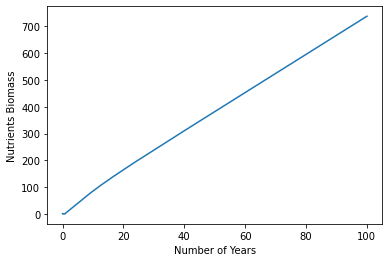

In [24]:
# Calculate the number of years in the simulation
numyears = parameters_dict['numyears']
years = numyears / 365

# Generate x-values representing years
time_years = np.linspace(0, years, len(H_array))

plt.plot(time_years, N_array)
plt.xlabel('Number of Years')
plt.ylabel('Nutrients Biomass')

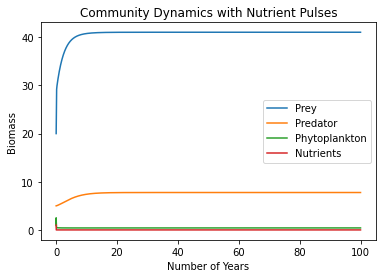

In [18]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Community Dynamics with Nutrient Pulses')

plt.savefig("figs/nutrient_pulse_all_abundances.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')


plt.show()

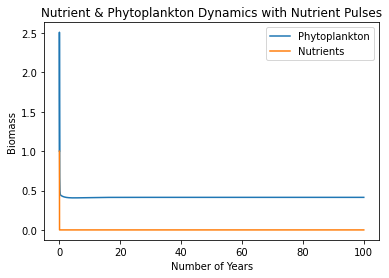

In [19]:
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Nutrient & Phytoplankton Dynamics with Nutrient Pulses')

plt.savefig("figs/nutrient_pulse_PH_N_abundances.jpg",
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

plt.show()

Text(0.5, 1.0, 'Nutrient & Phytoplankton Dynamics with Nutrient Pulses')

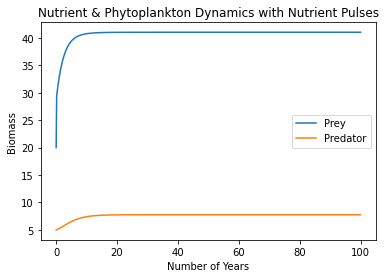

In [30]:
plt.plot(time_years, H_array, label= "Prey")
plt.plot(time_years, P_array, label= "Predator")
plt.legend()
plt.xlabel('Number of Years')
plt.ylabel('Biomass')
plt.title('Nutrient & Phytoplankton Dynamics with Nutrient Pulses')

In [32]:
# Define the range of b values to plot
size = 100
b_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, b in enumerate(b_array):
    parameters_dict['b'] = b
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-25:-1])
    P_final_array[i] = np.mean(P_array[-25:-1])

# Plot the final abundances
plt.plot(b_array, H_final_array, label='Prey', color="limegreen")
plt.plot(b_array, P_final_array, label='Predator', color="purple")
plt.title('Final Abundances Across $b$ Values (additional predator growth)')
plt.xlabel('$b$ Values')
plt.ylabel('Final Abundances')
plt.legend()

# Show the plot
plt.show()

KeyboardInterrupt: 

In [67]:
# Define the range of b values to plot
size = 50
E_H_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, E_H in enumerate(E_H_array):
    parameters_dict['E_H'] = E_H/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-25:-1])
    P_final_array[i] = np.mean(P_array[-25:-1])

# Plot the final abundances
plt.plot(E_H_array, H_final_array, label='Prey', color="limegreen")
plt.plot(E_H_array, P_final_array, label='Predator', color="purple")
plt.title('Final Abundances Across $E_H$ Values (herbivore fishing)')
plt.xlabel('$E_H$ Values')
plt.ylabel('Final Abundances')
plt.legend()

# Show the plot
plt.show()

KeyboardInterrupt: 

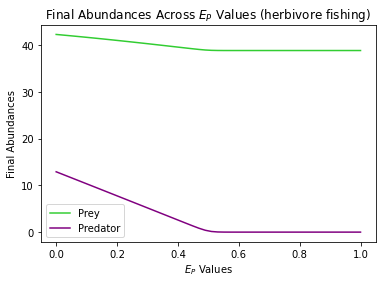

In [20]:
# Define the range of E_P values to plot
size = 50
E_P_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, E_P in enumerate(E_P_array):
    parameters_dict['E_P'] = E_P/365
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-25:-1])
    P_final_array[i] = np.mean(P_array[-25:-1])

# Plot the final abundances
plt.plot(E_P_array, H_final_array, label='Prey', color="limegreen")
plt.plot(E_P_array, P_final_array, label='Predator', color="purple")
plt.title('Final Abundances Across $E_P$ Values (herbivore fishing)')
plt.xlabel('$E_P$ Values')
plt.ylabel('Final Abundances')
plt.legend()

# Show the plot
plt.show()

In [44]:
P_nan = np.isnan(P_final_array)
np.argwhere(P_nan)

array([[26],
       [40],
       [41],
       [42]])

In [46]:
E_H_array[np.argwhere(P_nan)]

array([[0.53061224],
       [0.81632653],
       [0.83673469],
       [0.85714286]])

In [49]:
#Herbivore parameters:
r_H = (0.4/365) # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = (0.8/365) # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = (0.81632653/365) # Effort for herbivore harvest
m_H = (0.2/365) # Herbivore mortality 

#Predator parameters:
r_P = (0.4/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = (0.8/365) # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = (0.2/365) # Effort for predator harvest
m_P = (0.25/365) # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton ## daily rate ?
k_s = 0.116 # half saturation constant
m_ph = (0.01) # phytoplankton mortality ## daily rate ?
y = 0.1 # unassimilated phytoplankton 

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton ## daily ??
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }


numyears = 36500 # number of years to run simulation 

H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

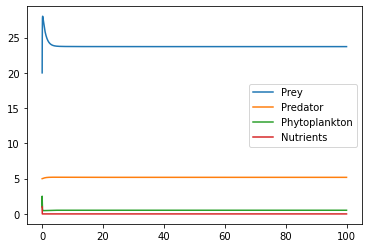

In [50]:
plt.plot(time_years, H_array, label="Prey")
plt.plot(time_years, P_array, label = "Predator")
plt.plot(time_years, PH_array, label= "Phytoplankton")
plt.plot(time_years, N_array, label= "Nutrients")
plt.legend()

In [35]:
# Define the range of b values to plot
size = 100
E_P_array = np.linspace(0.0, 1.0, size)
H_final_array = np.zeros(size)
P_final_array = np.zeros(size)

for i, E_P in enumerate(E_P_array):
    parameters_dict['E_P'] = E_P
    H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)
    H_final_array[i] = np.mean(H_array[-25:-1])
    P_final_array[i] = np.mean(P_array[-25:-1])

# Plot the final abundances
plt.plot(E_P_array, H_final_array, label='Prey', color="limegreen")
plt.plot(E_P_array, P_final_array, label='Predator', color="purple")
plt.title('Final Abundances Across $E_H$ Values (additional predator growth)')
plt.xlabel('$E_H$ Values')
plt.ylabel('Final Abundances')
plt.legend()

# Show the plot
plt.show()

KeyboardInterrupt: 